In [2]:
#!pip install packagename
# importing modules
import geopandas as gpd
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib
import matplotlib.pyplot as plt
import os
from os import chdir as cd
import time
import fiona
# import rasterio
# import rasterio.mask
# from rasterio.plot import show
# from rasterio.warp import calculate_default_transform, reproject, Resampling

C:\Users\uttar\anaconda3\envs\geopandasenv\lib\site-packages\geopandas\_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


In [3]:
# Exporting all shapefiles for plotting
# Importing the places shapefiles for all states
# combining them into one for further use
from pathlib import Path
# define the file location
folder = Path(r"D:\Work\Box Sync\Trends_all states\Maps_2020\\")
# reading the zip file
shapefiles = folder.glob("tl_2020_*_place.zip")
# combining places for US into one file
gdf = pd.concat([gpd.read_file(shp) for shp in shapefiles]).pipe(gpd.GeoDataFrame)
gdf = gdf.set_crs("EPSG:4269")
gdf.to_file(folder / 'compiled.shp')

C:\Users\uttar\anaconda3\envs\geopandasenv\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [4]:
US_places = gpd.read_file(r'D:\Work\Box Sync\Trends_all states\Maps_2020\compiled.shp')
US_counties = gpd.read_file(r'D:\Work\Box Sync\Trends_all states\Maps_2020\tl_2020_us_county.zip')
US_states = gpd.read_file(r'D:\Work\Box Sync\Trends_all states\Maps_2020\tl_2020_us_state.zip')

# source: https://gis.stackexchange.com/questions/141580/which-projection-is-best-for-mapping-the-contiguous-united-states
US_states = US_states.to_crs('EPSG:9311')
US_places = US_places.to_crs('EPSG:9311')
US_counties = US_counties.to_crs('EPSG:9311')

US_places.shape, US_counties.shape, US_states.shape

((32188, 17), (3234, 18), (56, 15))

In [5]:
US_places.groupby(['STATEFP'])['GEOID'].count().sum()

32188

In [6]:
# import Mann_kendall analysis data found from MK_trend_national
# for all places in the US
places_attr = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\mktest_place_10-20_Continued_labeled.csv')
places_attr['P_19'] = places_attr['Pop_estimate'].str.split(',').str[-2].str.strip('[]').astype(float)
places_attr.rename(columns = {'NAME_x': 'NAME'}, inplace = True)
# slicing column value to match with shapefile for joining
places_attr['GEOID'] = places_attr['GEO_ID'].str.slice(-7)
places_attr['State'] = places_attr['GEOID'].str[:2]
# places_attr = places_attr[places_attr['State'] == state_code]
#places_attr.head()

In [7]:
# Check number of values found from estimation
places_attr['label'].value_counts().sum()

29245

In [8]:
# joining tabular data with spatial data 
# by merging the data files based on column name
# use 'outer' join and check unmatched datanames
places_merged_all = US_places.merge(places_attr.loc[:,['GEOID','Pop_estimate', 'P_19', 'P_20', 'trend','label', 'State']],
                                    on = 'GEOID', 
                                    how = 'outer', 
                                    indicator=True)

In [9]:
places_merged = places_merged_all[places_merged_all['_merge'] == 'both']

In [10]:
# Excluding Puerto Rico since the forecast do not have values for Puerto Rico
places_merged = places_merged[places_merged['STATEFP'] != '72']

In [11]:
# places that exist in the geographic file (US_places) but not in population data
# these are places that changed NAME, GEOID or Both or merged or dropped
# they will be checked manually and analyzed separately
places_merged_all[places_merged_all['_merge'] == 'left_only'].sort_values('NAME').groupby(['STATEFP']).agg({'GEOID':'count',
                                                                                                            'P_19':'sum',
                                                                                                            'P_20':'sum'}).sum()

# places_merged_all[places_merged_all['_merge'] == 'left_only'][['GEOID', 'NAME', 'NAMELSAD','Pop_estimate',]]

GEOID    2943.0
P_19        0.0
P_20        0.0
dtype: float64

In [12]:
# County population
county_population = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\County Population\ACSDP5Y2020.DP05-Data.csv', header = 1)
county_population.shape
#county_population.head()

(3221, 715)

In [13]:
# loading forecasted population data from Hauer
%cd "D:\Work\Box Sync\Depop Population forecasting\NASA SEDAC data\county_projectios_Total_bySex_byRace\total_pop_proj"
county_Projection = gpd.read_file(r"hauer_county_totpop_SSPs.shp")

D:\Work\Box Sync\Depop Population forecasting\NASA SEDAC data\county_projectios_Total_bySex_byRace\total_pop_proj


In [14]:
# contains 3221 rows, 3135 rows contains forecast values, these 3135 rows will be used for analysis
county_Projection.shape
# 78 rows with zero data for counties in Puerto Rico
# county_Projection[county_Projection['STATEFP10'] == '72']
county_Projection = county_Projection[county_Projection['ssp32020'] != 0]
# check coordinate system and project to similar coordinate system
# to change the coordinate system
county_Projection = county_Projection.to_crs('3528')
if county_Projection.crs != places_merged.crs:
    places_merged = places_merged.to_crs(county_Projection.crs)
    

In [15]:
county_population['Estimate!!SEX AND AGE!!Total population'] = county_population['Estimate!!SEX AND AGE!!Total population'].astype('float')
county_population['GEOID10'] = county_population['Geography'].str.slice(-5)
county_Projection = county_Projection.merge(county_population[['GEOID10', 'Geographic Area Name',
                                                               'Estimate!!SEX AND AGE!!Total population']], on = 'GEOID10')

In [16]:
# county_Projection.columns
# total population in the US
# As of the census, 26% of the people in the United States lived outside of places
places_merged['P_20'].sum()/(1-0.26)

328109586.4864865

In [17]:
df_P_20_with_margin = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\Population_2020_with_margin.csv')
df_P_20_with_margin['GEOID'] = df_P_20_with_margin['GEO_ID'].str.slice(-7)

In [18]:
county_Projection['STATEFP10'].sort_values().unique()[:2]

array(['01', '02'], dtype=object)

In [19]:
combined_df = pd.DataFrame()
gdf = pd.DataFrame()

for state in county_Projection['STATEFP10'].sort_values().unique():
    # print('start...')
    # print('........')
    population_projection =  county_Projection[county_Projection['STATEFP10'] == state]
    places_population = places_merged[places_merged['STATEFP'] == state]
    
    # print(population_projection.head())
    # print('........')
    # print(places_population.head())
    
    if population_projection.crs == places_population.crs:
        # calculating total area from geometry # try using land/water ratio???? # didnt use geom_area, used ALAND area
        geom_overlayed = gpd.overlay(population_projection, places_population, how='intersection', keep_geom_type=False, make_valid=True)

        geom_overlayed['intersect_area'] = geom_overlayed.area
    
        geom_overlayed['%area'] = geom_overlayed['intersect_area'] /geom_overlayed['ALAND'] 
        geom_overlayed['area_factor'] = geom_overlayed.groupby(by = ['GEOID'])['%area'].apply(lambda x:(x/x.sum()))
        geom_overlayed['landarea'] = geom_overlayed['ALAND'] / (1000*1000)
        # density in km2
        geom_overlayed['density'] = geom_overlayed['P_20']/geom_overlayed['landarea'] 
        geom_overlayed['P_20_adjusted'] = geom_overlayed['area_factor'] * geom_overlayed['density'] * geom_overlayed['landarea']
        # what percent of county population lives in this place
        geom_overlayed['population_factor'] = geom_overlayed['P_20_adjusted'] / geom_overlayed['Estimate!!SEX AND AGE!!Total population'] #.apply(lambda x:(x/x.sum()))
    
        # geom_overlayed['population_factor'] = geom_overlayed.groupby(by = ['STATEFP', 'NAMELSAD10'])['P_20_adjusted'].apply(lambda x:(x/x.sum()))
        geom_overlayed['population_factor'] = geom_overlayed['population_factor'].fillna(0)
        # normalizing population factor so that county total becomes 1
        # geom_overlayed['population_factor'] = geom_overlayed.groupby(by = ['STATEFP10', 'NAMELSAD10'])['population_factor'].apply(lambda x:(x/x.sum()))
        # print(geom_overlayed.shape)
        for colidx in range(18, 63):
            column_name =  'forecast_' + str(geom_overlayed.columns[colidx])
            geom_overlayed[column_name] = (geom_overlayed.iloc[:,colidx] * geom_overlayed['population_factor']).round(0)
        
        gdf = pd.concat([gdf, geom_overlayed])
    
        column_name = geom_overlayed.columns[136:181] # taking the columns that have forecasted dataset
        forecasted_df = pd.DataFrame()
        forecasted_df = geom_overlayed.groupby(by = ['GEOID'], as_index=False)[column_name].apply(lambda x:(x.sum()))

        county_names = geom_overlayed.groupby(by = ['GEOID'], as_index=False).agg({'COUNTYFP10': 'first', 'NAME10': 'count'})
        forecasted_df =  forecasted_df.merge(county_names, on = 'GEOID')
    
    
        df_with_MOE = forecasted_df.merge(df_P_20_with_margin[df_P_20_with_margin['GEOID'].str.startswith(state)][['P_20_upper', 
                                                                                                               'P_20_lower','NAME', 'GEOID',]], on = 'GEOID')
    
        df_with_MOE['MOE'] = (df_with_MOE['P_20_upper']- df_with_MOE['P_20_lower'])/2
        df_with_MOE['diff'] = (df_with_MOE['P_20_upper']- df_with_MOE['MOE']- df_with_MOE['forecast_ssp32020'])
        df_with_MOE['diff'] = df_with_MOE['diff'].replace(-np.inf, np.nan)
        # print('Completed for state: ' + state)

        combined_df = pd.concat([combined_df, df_with_MOE])
    else:
        print('check coordinate system')
    
    
    
combined_df.shape

(28930, 53)

In [20]:
28930-28679

251

In [21]:
# plotting_city = gdf[(gdf['NAMELSAD'] =='Hampton city') & (gdf['%area'] > 0.001)].plot() #
# plotting_city[['GEOID', 'NAME10', 'NAMELSAD', '%area', 'P_20', 'forecast_ssp32020']].sort_values('%area')

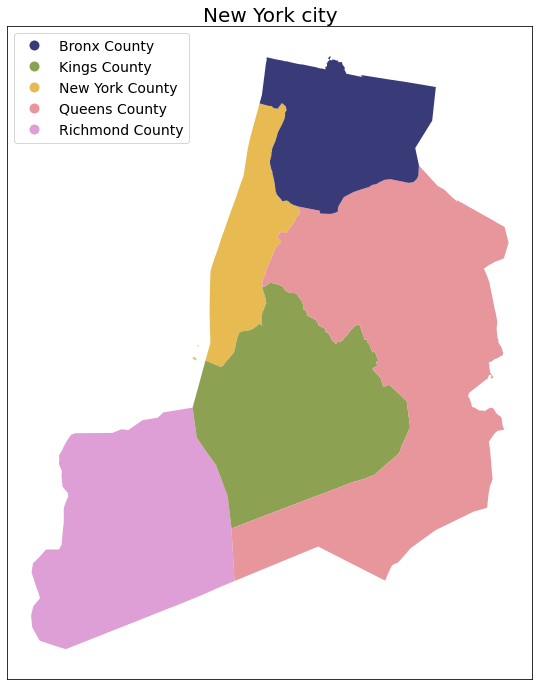

In [22]:
# =====================================================
# # find the city that is overlaped by maximum counties
# =====================================================
city_name = 'New York city'
plotting_city = gdf[(gdf['NAMELSAD'] ==city_name) & (gdf['%area'] > 0.001)]
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 12))
# county_IL[county_IL['NAME'] == 'Kane'].plot(ax= ax, edgecolor = 'green',  facecolor = 'none')
# county_IL[county_IL['NAME'] == 'Kendall'].plot(ax= ax, edgecolor = 'red', facecolor = 'none')
# county_IL[county_IL['NAME'] == 'DuPage'].plot(ax= ax, edgecolor = 'blue', facecolor = 'none')
# county_IL[county_IL['NAME'] == 'Will'].plot(ax= ax, edgecolor = 'pink', facecolor = 'none')#, column = 'NAME10', legend = True, cmap = 'tab20b', legend_kwds={'loc': 'lower left',})
plotting_city.plot(ax= ax, column = 'NAMELSAD10', legend = True, 
                   cmap = 'tab20b', legend_kwds={'loc': 'upper left','fontsize': 14})
ax.set_title(str(city_name), fontsize=20, pad=5)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
fig.savefig(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\Figures\\' + str(city_name) + '.png', dpi =300, bbox_inches='tight')


In [23]:
# gdf.groupby(['STATEFP', 'GEOID']).agg({'NAMELSAD': 'first',
#                                      'ssp32020':'first', # 'STATEFP','GEOID',
#                                     'P_19':'first',
#                                     'P_20': 'first',
#                                     'forecast_ssp32020': 'sum',
#                                     # 'area_factor':'sum',
#                                     'population_factor':'sum',
#                                     # 'diff':'sum',
#                                    # 'ALAND':'first',
#                                   }) #.sort_values('diff') #.reset_index() #.sort_values('NAMELSAD')

In [24]:
# combined_df['forecast_ssp32020'].sum() / county_Projection['ssp32020'].sum()

In [25]:
forecasted_df = combined_df.reset_index().copy()

In [26]:
forecasted_df['find_trend_ssp1'] = forecasted_df[['forecast_ssp12020', 'forecast_ssp12025', 'forecast_ssp12030', 'forecast_ssp12035', 
                                              'forecast_ssp12040','forecast_ssp12045', 'forecast_ssp12050', 'forecast_ssp12055', 
                                              'forecast_ssp12060']].astype(str).fillna('').apply(', '.join, axis=1)
forecasted_df['find_trend_ssp2'] = forecasted_df[['forecast_ssp22020', 'forecast_ssp22025', 'forecast_ssp22030', 
                                              'forecast_ssp22035', 'forecast_ssp22040','forecast_ssp22045', 'forecast_ssp22050',
                                             'forecast_ssp22055', 'forecast_ssp22060']].astype(str).fillna('').apply(', '.join, axis=1)
forecasted_df['find_trend_ssp3'] = forecasted_df[['forecast_ssp32020', 'forecast_ssp32025', 'forecast_ssp32030', 'forecast_ssp32035', 
                                              'forecast_ssp32040','forecast_ssp32045', 'forecast_ssp32050', 'forecast_ssp32055', 
                                              'forecast_ssp32060']].astype(str).fillna('').apply(', '.join, axis=1)
forecasted_df['find_trend_ssp4'] = forecasted_df[['forecast_ssp42020', 'forecast_ssp42025', 'forecast_ssp42030', 
                                              'forecast_ssp42035', 'forecast_ssp42040','forecast_ssp42045', 'forecast_ssp42050',
                                             'forecast_ssp42055', 'forecast_ssp42060']].astype(str).fillna('').apply(', '.join, axis=1)
forecasted_df['find_trend_ssp5'] = forecasted_df[['forecast_ssp52020', 'forecast_ssp52025', 'forecast_ssp52030', 'forecast_ssp52035', 
                                              'forecast_ssp52040','forecast_ssp52045', 'forecast_ssp52050', 'forecast_ssp52055', 
                                              'forecast_ssp52060']].astype(str).fillna('').apply(', '.join, axis=1)

In [27]:
import pymannkendall as mk
import numpy as np
test_res = []

column_name = ['find_trend_ssp1','find_trend_ssp2', 'find_trend_ssp3', 'find_trend_ssp4', 'find_trend_ssp5']

for i in range(0,len(column_name)):
    for j in range(0,len(forecasted_df[column_name])):
        test_res.append(mk.original_test(np.asarray([float(k) for k in forecasted_df.iloc[j][column_name[i]].split(',')]), alpha=0.05))  

for i in range(0,len(column_name)):
    new_col_name = 'result' + column_name[i][10:]
    forecasted_df[new_col_name] =  test_res[(i*len(df)):(i+1)*len(forecasted_df)]

In [28]:
forecasted_df['expected_trend_1'] = ''
forecasted_df['expected_trend_2'] = ''
forecasted_df['expected_trend_3'] = ''
forecasted_df['expected_trend_4'] = ''
forecasted_df['expected_trend_5'] = ''

In [29]:
for i in range(len(forecasted_df)):
    forecasted_df['expected_trend_1'][i] = forecasted_df['result_ssp1'][i][0]
    forecasted_df['expected_trend_2'][i] = forecasted_df['result_ssp2'][i][0]
    forecasted_df['expected_trend_3'][i] = forecasted_df['result_ssp3'][i][0]
    forecasted_df['expected_trend_4'][i] = forecasted_df['result_ssp4'][i][0]
    forecasted_df['expected_trend_5'][i] = forecasted_df['result_ssp5'][i][0]

C:\Users\uttar\AppData\Local\Temp\ipykernel_17480\1922735487.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecasted_df['expected_trend_1'][i] = forecasted_df['result_ssp1'][i][0]
C:\Users\uttar\AppData\Local\Temp\ipykernel_17480\1922735487.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecasted_df['expected_trend_2'][i] = forecasted_df['result_ssp2'][i][0]
C:\Users\uttar\AppData\Local\Temp\ipykernel_17480\1922735487.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

In [72]:
# forecasted_df.columns

In [75]:
# =========== DEFINING df for use rest of the section
# joining table data with spatial data
df = places_merged.merge(forecasted_df, left_on='GEOID', right_on='GEOID', how = 'left')
df_notnull = df[df['diff'].notnull()]

df_notnull[['STATEFP','NAMELSAD', 'NAME10', 'P_19', 'P_20_upper', 'P_20_lower', 'P_20','forecast_ssp32020','forecast_ssp42020', 'diff', 
                             'label','expected_trend_3',]].sort_values('diff')

df_notnull[(df_notnull['forecast_ssp32020'] > df_notnull['P_20_upper']) |
     (df_notnull['forecast_ssp32020'] < df_notnull['P_20_lower'])][['GEOID', 'NAMELSAD', 'P_19', 'P_20_upper',
                                                        'P_20_lower', 'P_20','forecast_ssp32020','forecast_ssp32030', 'forecast_ssp32040', 
                                                        'diff', 'label', 'expected_trend_3']].sort_values('diff').shape

df_notnull[(df_notnull['forecast_ssp32020'] < df_notnull['P_20_upper']) &
     (df_notnull['forecast_ssp32020'] > df_notnull['P_20_lower'])][['P_20_upper',
                                                        'P_20_lower', 'P_20','forecast_ssp32020', 'diff']].sort_values('diff').shape

(23379, 5)

In [76]:
df['expected_trend_2'].value_counts(), df['expected_trend_3'].value_counts()
#[['STATEFP', 'NAMELSAD', 'P_19','P_20', 'COUNTYFP10', 'forecast_ssp32020']]
# df.groupby(['trend', 'expected_trend_2', 'expected_trend_3'])['GEOID'].count()

(decreasing    15451
 increasing    11217
 no trend       2262
 Name: expected_trend_2, dtype: int64,
 decreasing    21639
 increasing     4756
 no trend       2535
 Name: expected_trend_3, dtype: int64)

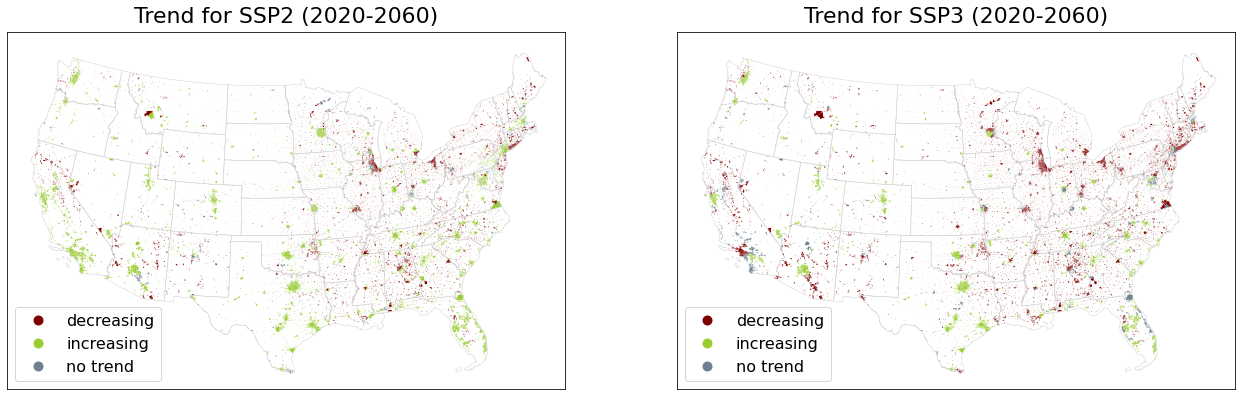

In [77]:
df = df.to_crs('EPSG:9311')
#US_states = US_states.to_crs('EPSG:9311')
columns = ['expected_trend_2', 'expected_trend_3'] 
colors = ['maroon','yellowgreen','slategray']
title_dict = {'trend':'Trend from ACS data 2010-2020', 'expected_trend_1':'Trend for SSP1 (2020-2060)', 
              'expected_trend_2':'Trend for SSP2 (2020-2060)', 'expected_trend_3': 'Trend for SSP3 (2020-2060)',
              'expected_trend_4': 'Trend for SSP4 (2020-2060)', 'expected_trend_5':'Trend for SSP5 (2020-2060)'}

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(22,12))

for ax,col in zip(ax.flatten(), columns):
    xlim = ([-2257388.37, 2695859.75]) 
    ylim = ([-2246944.04, 918095.9])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    cmap_colors = matplotlib.colors.ListedColormap(colors)
    base = US_states.boundary.plot(ax =ax, edgecolor = 'lightgray', linewidth = 0.5)
    df.plot(ax =ax, column = col, cmap=cmap_colors, legend = True, legend_kwds={'loc': 'lower left','fontsize': 16, })
    ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    ax.set_title(title_dict.get(col), fontsize=22, pad=10)

# fig.savefig(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\Figures\All Trends from forecast.png', dpi = 900)

In [78]:
# #df.groupby(['label'])['expected_trend_3'].count()
# # df['label'] / df.groupby(['label'])['expected_trend_3'].transform('sum')

# df.groupby(['expected_trend_2', 'label', ]).agg({'label': 'count'}).groupby(level=0).apply(lambda x: (100 * x / float(x.sum())).round(2)).plot()
# df.groupby(['expected_trend_3', 'label', ]).agg({'label': 'count'}).groupby(level=0).apply(lambda x: (100 * x / float(x.sum())).round(2)).plot()
# df[df['expected_trend_3'].isnull()]['STATEFP'].unique()
# # missing values in Alaska and South Dakota
# # df.shape

In [79]:
df.shape, df_not_null.shape
# df['diff'] = (df['P_20']- df['forecast_ssp32020'])/df['P_20']

((28995, 92), (28995, 92))

In [122]:
# df[~df['diff'].notnull()][['STATEFP','NAMELSAD', 'NAME10', 'P_19', 'P_20_upper', 'P_20_lower', 'P_20','forecast_ssp32020','forecast_ssp42020', 'diff', 
#                              'label','expected_trend_3',]].sort_values('diff')

In [67]:
df[(df['forecast_ssp32020'] ==0) & (df['forecast_ssp32040'] ==0)]['expected_trend_3'].value_counts()
df.shape[0]-251
32188-28744

3444

In [68]:
df['density_km2'] = df['P_20'] *1000*1000 / df['ALAND']
# df[df['density_km2'] == 0][df[df['density_km2'] == 0]['NAMELSAD'].str.contains('CDP')==False][['Pop_estimate', 'P_19', 'P_20']]

In [69]:
# df[df['density_km2'] != 0].groupby('expected_trend_2')['density_km2'].describe().round(2)

In [70]:
# df[df['P_20'] >100000].groupby('expected_trend_3')['density_km2'].describe().round(2)

In [71]:
df[df['density_km2'] != 0].groupby('label')['density_km2'].describe().round(2)
df[df['density_km2'] != 0].groupby('expected_trend_3')['density_km2'].describe().round(2)
df[df['density_km2'] != 0].groupby('expected_trend_2')['density_km2'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
expected_trend_2,,,,,,,,
decreasing,15451.0,361.78,405.91,0.01,104.14,251.41,473.61,6843.82
increasing,11217.0,723.65,1031.05,0.02,149.63,413.45,916.44,29930.29
no trend,2011.0,467.80,530.41,0.04,124.97,310.06,602.21,4276.07


<AxesSubplot:xlabel='Expected Trend', ylabel='No of cities'>

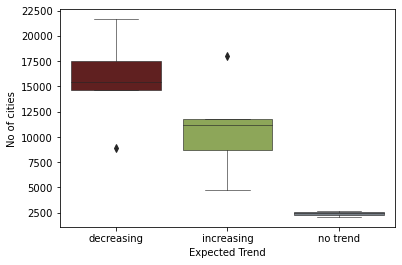

In [116]:
trend_sce_df = pd.DataFrame()
trend_sce_df['SSP 1'] = df['expected_trend_1'].value_counts()
trend_sce_df['SSP 2'] = df['expected_trend_2'].value_counts()
trend_sce_df['SSP 3'] = df['expected_trend_3'].value_counts()
trend_sce_df['SSP 4'] = df['expected_trend_4'].value_counts()
trend_sce_df['SSP 5'] = df['expected_trend_5'].value_counts()

import seaborn as sns
sns.boxplot(x="Expected Trend", y="No of cities", 
            data=pd.melt(trend_sce_df.T, var_name='Expected Trend', value_name='No of cities', col_level=None, ignore_index=False),
            palette = ['maroon','yellowgreen','slategray'],
            saturation=0.5,
            linewidth=0.6,
           )

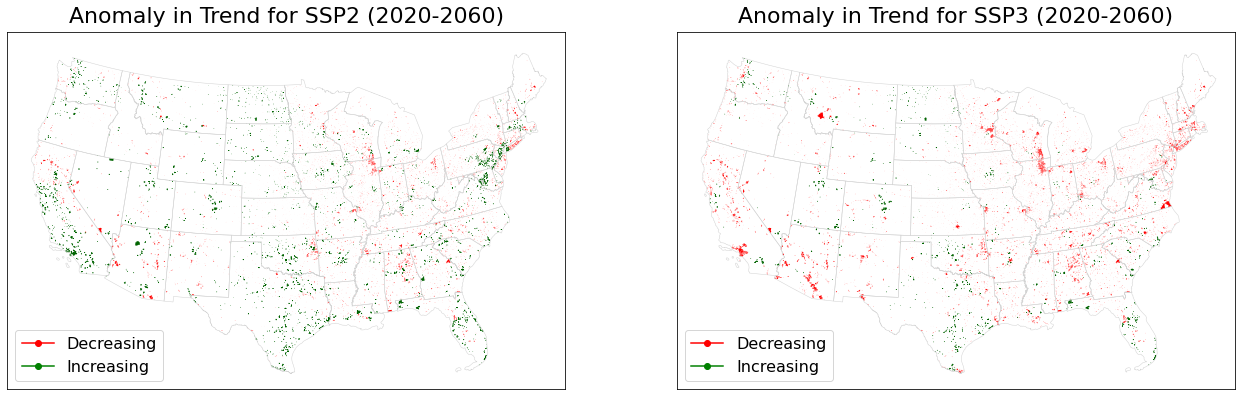

In [117]:
from matplotlib import lines
#US_states = US_states.to_crs('EPSG:9311')
columns = ['expected_trend_2', 'expected_trend_3'] 
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(22,12))

for ax,col in zip(ax.flatten(), columns):
    xlim = ([-2257388.37, 2695859.75]) 
    ylim = ([-2246944.04, 918095.9])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    cmap_colors = matplotlib.colors.ListedColormap(colors)
    base = US_states.boundary.plot(ax =ax, edgecolor = 'lightgray', linewidth = 0.5)
    df[(df[col] == 'increasing') & (df['label'].str.contains('depopulating'))].plot(ax =ax, color = 'darkgreen', 
                                                                                                   edgecolor = 'darkgreen', 
                                                                                                   linewidth = 0.4, legend = True, 
                                                                                                   legend_kwds={'loc': 'lower left','fontsize': 16})
    df[(df[col] == 'decreasing') & (df['label'].str.contains('increasing'))].plot(ax =ax, color = 'red', legend = True, 
                                                                                                   legend_kwds={'loc': 'lower left','fontsize': 16})
    ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    ax.set_title('Anomaly in ' + title_dict.get(col), fontsize=22, pad=10)
    ax.legend([lines.Line2D([0], [0], marker='o', ls='solid', c='red'),
               lines.Line2D([0], [0], marker='o',ls='solid', c='green'),],
              ['Decreasing', 'Increasing'],
              loc = 'lower left', fontsize = 16)

fig.savefig(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\Figures\Anomaly in trend_current_forecast.png', dpi = 300)

In [123]:
df['density_km2'] = df['P_20'] * 1000 * 1000 / df['ALAND']

In [136]:
df[df['density_km2'] != 0]['density_km2'].min()

0.01019276731918875

In [139]:
# df['diff'].min()

In [124]:
# df[df['density_km2'] != 0].shape[0] , df[df['density_km2'] == 0].shape[0]

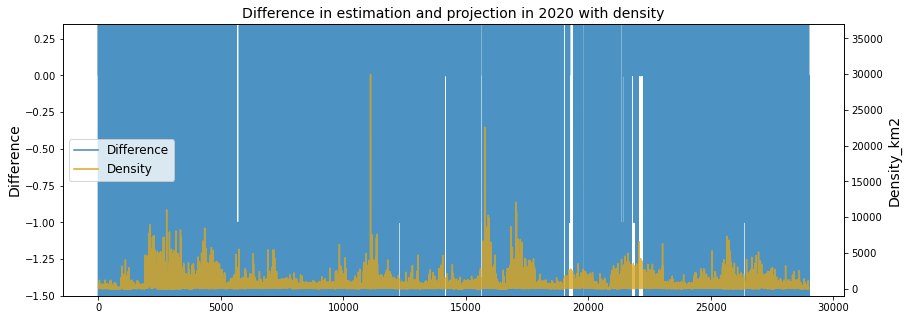

In [133]:
# create figure and axis objects with subplots()

fig,ax=plt.subplots(figsize=(14,5))
df['diff'].plot(ax=ax, alpha = 0.8, label = 'Difference')
ax.set_ylim(-1.5, 0.35)
ax.set_ylabel("Difference",fontsize=14)
ax.set_title('Difference in estimation and projection in 2020 with density', fontsize=14)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
df[df['density_km2'] != 0]['density_km2'].plot(ax=ax2, color="goldenrod", alpha = 0.8, label = 'Density')
ax2.set_ylabel("Density_km2",fontsize=14, )
ax2.set_ylim(-1000, 37000)

ax.legend([lines.Line2D([0], [0], ls='solid', c='steelblue'),
           lines.Line2D([0], [0], ls='solid', c='goldenrod'),],
              ['Difference', 'Density'],
              loc = 'center left', fontsize = 12)

plt.show()

In [140]:
from datetime import date

today = date.today()

file_name = 'forecasted_trend_' + str(date.today())
df.to_csv(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\\' + file_name + '.csv')

In [141]:
'''
Not everyone resides in a place; in 1990, approximately 66 million people (26 percent) in the United States lived outside of any place, 
either in small settlements, in the open countryside, or in the densely settled fringe of large cities in areas that were built-up, 
but not identifiable as places. 

'''

'\nNot everyone resides in a place; in 1990, approximately 66 million people (26 percent) in the United States lived outside of any place, \neither in small settlements, in the open countryside, or in the densely settled fringe of large cities in areas that were built-up, \nbut not identifiable as places. \n\n'

In [142]:
county_Projection[['ssp32020', 'ssp32040', 'ssp32050', 'ssp32060']].sum(), forecasted_df[['forecast_ssp32020', 'forecast_ssp32040', 'forecast_ssp32050', 'forecast_ssp32060', ]].sum()
245375572.0/3.287417e+08, 256977104.0/3.388857e+08, 255146017.0/3.342000e+08, 250260502.0/3.260763e+08

(0.74640841730757, 0.7583002292513376, 0.7634530730101735, 0.7674906210601629)

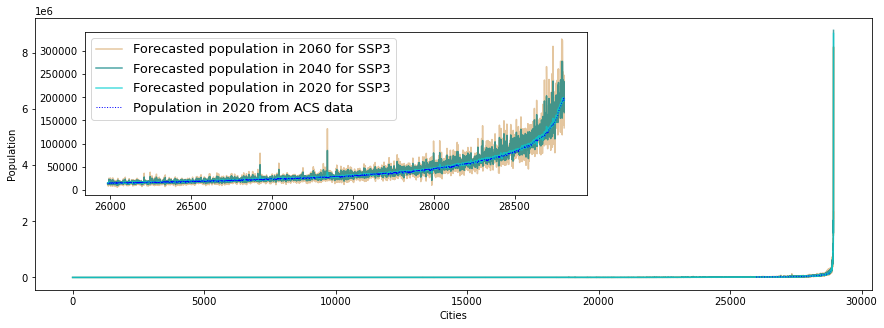

In [143]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

df_main = forecasted_df.sort_values('P_20_upper').reset_index()
df_inset= df_main[(df_main['forecast_ssp32020'] < 200000) & (df_main['P_20_upper'] > 15000)]

fig, ax = plt.subplots(1, 1, figsize=[15, 5])
ax.plot(df_main.index, df_main['forecast_ssp32060'], "burlywood", alpha = 0.8, label = 'forecasted population 2060 for SSP3');
ax.plot(df_main.index, df_main['forecast_ssp32040'],"teal", alpha = 0.7, label = 'forecasted population 2040 for SSP3');
ax.plot(df_main.index, df_main['forecast_ssp32020'], "darkturquoise", alpha = 0.7, label = 'forecasted population 2020 for SSP3');
ax.plot(df_main.index, (df_main['P_20_upper'] - df_inset['MOE']), "b",linestyle='dotted', linewidth=1, label = 'Population in 2020 from ACS data')

# ax.fill_between(df_main.index, df_main['P_20_upper'], df_main['P_20_lower'], color="grey", alpha=0.5);

# Create inset of mixed specifications in the second subplot;
# width is 30% of parent axes' bounding box and
# height is 1 inch at the upper left corner (loc=2)
#Get artists and labels for legend and chose which ones to display

ax1 = ax.inset_axes((0.06,0.35,.6,.6)) #inset_axes(ax, width="50%", height=2, loc=2, borderpad=5)

ax1.plot(df_inset.index, df_inset['forecast_ssp32060'], "burlywood", alpha = 0.8, label = 'Forecasted population in 2060 for SSP3');
ax1.plot(df_inset.index, df_inset['forecast_ssp32040'],"teal", alpha = 0.7, label = 'Forecasted population in 2040 for SSP3');
ax1.plot(df_inset.index, df_inset['forecast_ssp32020'], "darkturquoise", alpha = 0.7, label = 'Forecasted population in 2020 for SSP3');
ax1.plot(df_inset.index, (df_inset['P_20_upper'] - df_inset['MOE']), "b",linestyle='dotted', linewidth=1, label = 'Population in 2020 from ACS data')

ax1.fill_between(df_inset.index, df_inset['P_20_upper'], df_inset['P_20_lower'], color="grey", alpha=0.5);

display = (0,1,2,3,4)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend([handle for i,handle in enumerate(handles) if i in display],
           [label for i,label in enumerate(labels) if i in display], loc = 'best', fontsize = 13)


# Turn ticklabels of insets off
for axi in [ax, ax1]:
    axi.tick_params(labelleft=True, labelbottom=True)
ax.set_xlabel('Cities')
ax.set_ylabel('Population')
plt.show()

fig.savefig(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\Figures\Plot variation in estimation and projected values.png', dpi = 300,
           bbox_inches='tight', transparent="True", pad_inches=0)

In [144]:
# county_Projection.crs, places_merged.crs

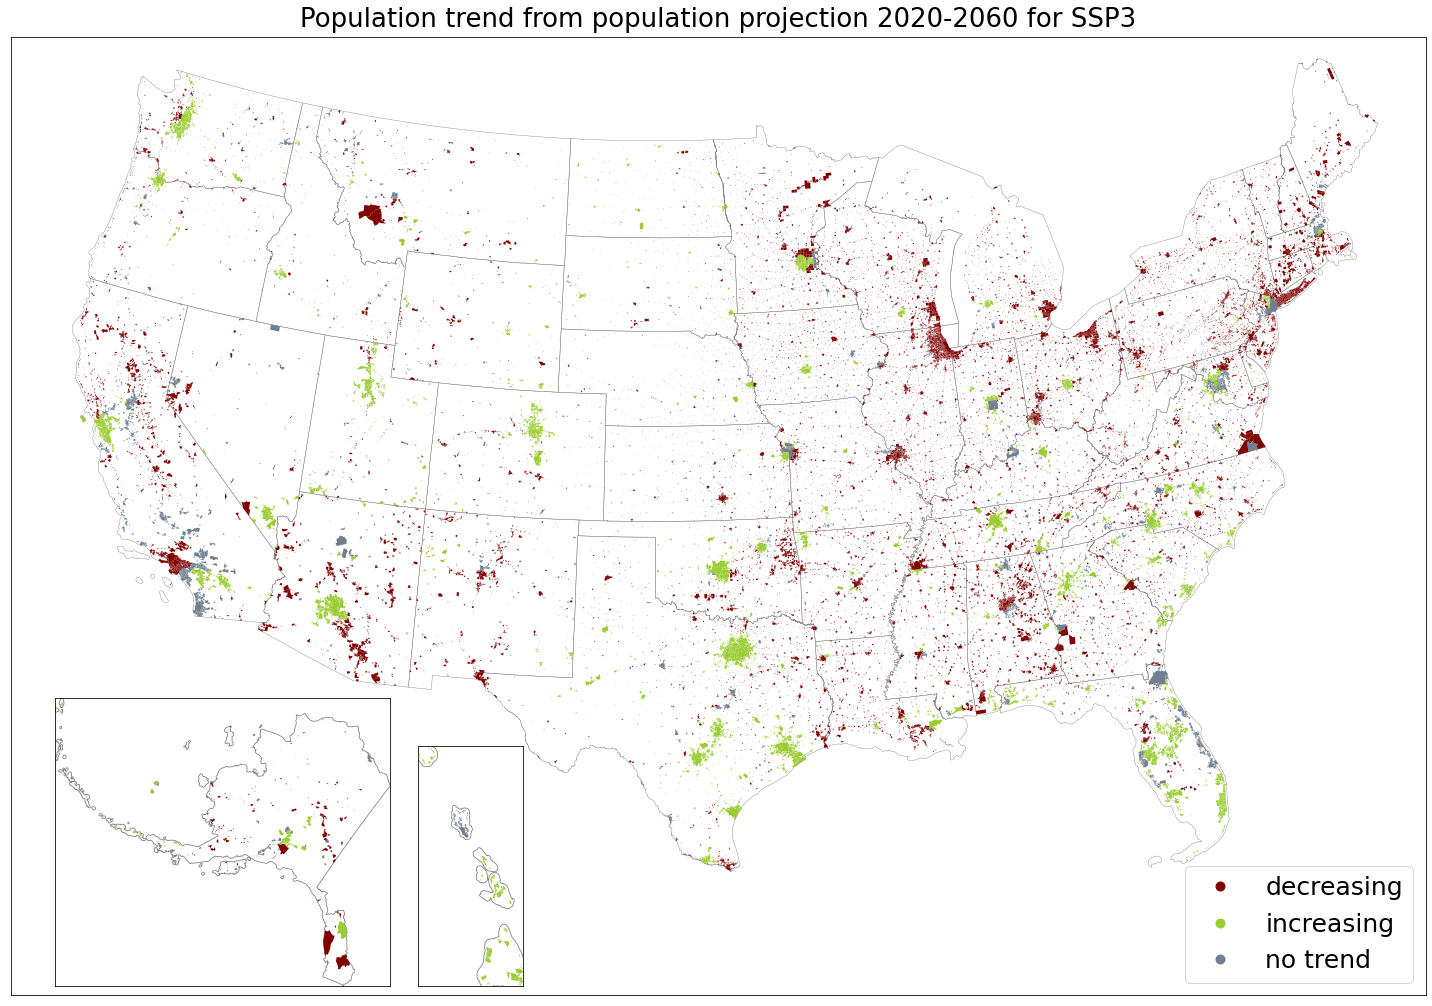

In [145]:
# import the United States shape file
# set state code as index, exclude states that we will never display
gdf = df.set_index('STATEFP') #.drop(index=['02', 'VI', 'MP', 'GU', 'AS'])
colors = ['maroon','yellowgreen','slategray']
column_name = "expected_trend_3"
# create an axis with 2 insets − this defines the inset sizes
fig, continental_ax = plt.subplots(figsize=(20, 20))
alaska_ax = continental_ax.inset_axes([.01, .01, .28, .30])
hawaii_ax = continental_ax.inset_axes([.20, .01, .25, .25])

# Set bounds to fit desired areas in each plot
continental_ax.set_xlim(-2257388.37, 2695859.75)
continental_ax.set_ylim(-2546944.04, 808080.9)
#[-8532676.07614065, -3748050.80000724,  3754325.60307967, 4852777.56870515]
alaska_ax.set_xlim(-4383115.86156959, -1515327.22537998)
alaska_ax.set_ylim(1458524.37417163, 3919523.37426209)

hawaii_ax.set_xlim(-5722090.887043, -5462538.83170424)   # bounds found for only populated places in Hawaii
hawaii_ax.set_ylim(-1044618.58269969, -455238.37803499)
#[-6440340.62278472, -1056683.73964088, -5453622.10058784, 1580494.49019997] # total bounds for Hawaii

# Plot the data per area - requires passing the same choropleth parameters to each call
# because different data is used in each call, so automatically setting bounds won’t work
#vmin, vmax = df['ALAND'].agg(['min', 'max'])
US_states.plot(ax=continental_ax, facecolor = 'none', edgecolor='gray', linewidth=0.4)
gdf.plot(column=column_name, 
                                  ax=continental_ax,
                                  cmap=matplotlib.colors.ListedColormap(colors), 
                                  legend = True,
                                  legend_kwds={'loc': 'lower right', 'fontsize': 25,}) #, vmin=vmin, vmax=vmax)

US_states.plot(facecolor = 'none', edgecolor='gray', linewidth=0.8, ax=alaska_ax)
gdf.plot(column=column_name, cmap=matplotlib.colors.ListedColormap(colors), ax=alaska_ax) #, vmin=vmin, vmax=vmax)

US_states.plot(facecolor = 'none', edgecolor='gray', linewidth=0.8, ax=hawaii_ax)
gdf.plot(column=column_name, cmap=matplotlib.colors.ListedColormap(colors), ax=hawaii_ax,
                    missing_kwds = dict(color='black')) #, vmin=vmin, vmax=vmax)

# remove ticks
for ax in [continental_ax, alaska_ax, hawaii_ax]:
    ax.set_yticks([])
    ax.set_xticks([])
    plt.tight_layout() 
    
continental_ax.set_title('Population trend from population projection 2020-2060 for SSP' + column_name[-1:], fontsize=26, pad=10)
fig.savefig(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\Figures\all states trend for SSP_' + str(column_name) + '.png', dpi = 300,
           bbox_inches='tight')

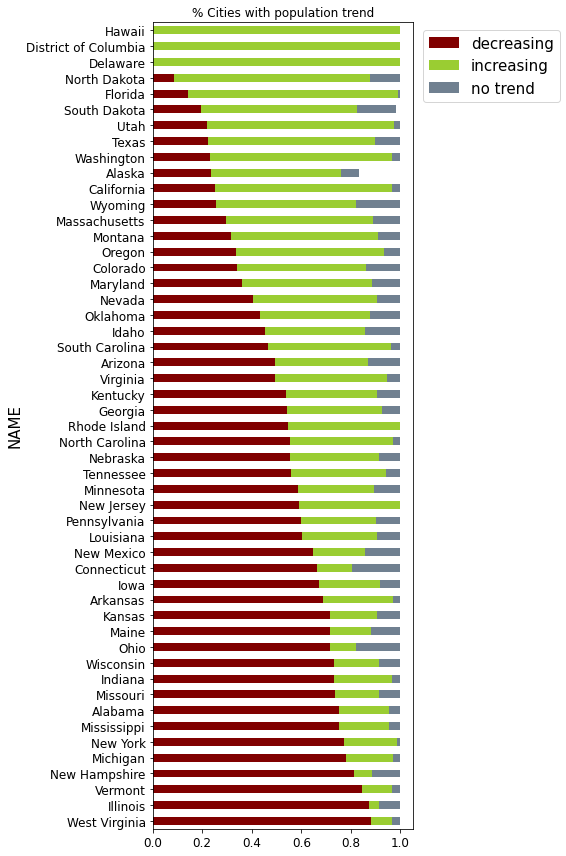

In [146]:
# get state names
state_names= US_states[['STATEFP', 'NAME']]
# Percent cities in each trend group
# pd.set_option('display.max_rows', None)

column_name = 'expected_trend_2'

percent_cities = (df.groupby(['STATEFP', column_name]).count()[['GEOID']] /
                  df.groupby(['STATEFP']).count()[['GEOID']]).reset_index()

table = pd.pivot_table(percent_cities, values='GEOID', index=['STATEFP'], # 'expected_trend_3'
                    columns=[column_name], aggfunc=np.sum).reset_index()

table = table.merge(state_names, on = 'STATEFP')
# table['sum'] = table[['1 severely depopulating', '2 moderately depopulating','3 slowly depopulating']].sum(axis =1)
table = table.sort_values('decreasing', ascending = False) 
table.drop(columns = ['STATEFP',], inplace = True)

colors = ['maroon','yellowgreen','slategray']
# colors = ['red', 'maroon', 'indianred', 'darkorange', 'limegreen','forestgreen', 'darkgreen', 'gray']
cmap=matplotlib.colors.ListedColormap(colors)

# plot a Stacked Bar Chart using matplotlib
ax = table.plot(
    x = 'NAME',
    kind = 'barh',
    stacked = True,
    cmap = cmap,
    title = '% Cities with population trend',
    mark_right = True,
    figsize=(8, 12))
# setting label sizes after creation
ax.yaxis.label.set_size(15)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(bbox_to_anchor=(1.01, 1.00), loc='upper left', prop={'size': 15})
plt.tight_layout()
plt.show()
fig = ax.get_figure()
fig.savefig(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\Figures\pct cities with pop trend_' + str(column_name) + '.png', dpi = 300)

In [147]:
# table[table['decreasing'] > 0.50].reset_index()

In [148]:
print('States with 50% or above no of cities with a decreasing trend: SSP3, SSP2'), 43/51, 29/51

len(table), 43*50*28600/100/51, 12000-11803, 12000/30000

States with 50% or above no of cities with a decreasing trend: SSP3, SSP2


(None, 0.8431372549019608, 0.5686274509803921)

In [151]:
# df.groupby(['expected_trend_2','label'])['density_km2'].describe().round(2)

In [152]:
# adding US regions to the data
# Region 1: Northeast, Region 2: Midwest, Region 3: South, Region 4: West source: wiki
df = df.merge(US_states[['REGION', 'DIVISION', 'STATEFP']], on = 'STATEFP')

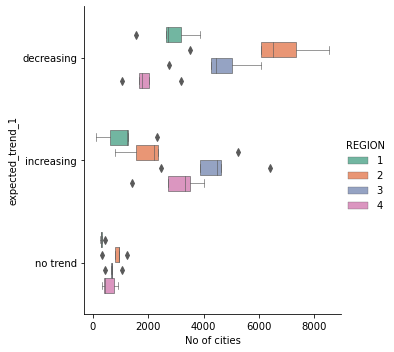

In [210]:
trend_sce_df = pd.DataFrame()
trend_sce_df['SSP 1'] = df.groupby('REGION')['expected_trend_1'].value_counts()
trend_sce_df['SSP 2'] = df.groupby('REGION')['expected_trend_2'].value_counts()
trend_sce_df['SSP 3'] = df.groupby('REGION')['expected_trend_3'].value_counts()
trend_sce_df['SSP 4'] = df.groupby('REGION')['expected_trend_4'].value_counts()
trend_sce_df['SSP 5'] = df.groupby('REGION')['expected_trend_5'].value_counts()

import seaborn as sns
sns.catplot(y="expected_trend_1", x="No of cities", 
            data=pd.melt(trend_sce_df, value_name='No of cities', col_level=None, ignore_index=False).reset_index(),
            palette =sns.set_palette('Set2'),
            kind = 'box',
            hue = 'REGION',
            width = .6,
            # saturation=0.5,
            linewidth=0.6,
           )

In [224]:
df[['STATEFP', 'GEOID', 'NAMELSAD','P_20', 'trend', 'label', 'State', 'COUNTYFP10', 'NAME10', 
    'expected_trend_1', 'expected_trend_2', 'expected_trend_3', 'expected_trend_4', 'expected_trend_5', 'REGION', 
    'DIVISION']].to_csv(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\expected_trend_' + str(date.today()) + '.csv')

In [212]:
pd.set_option('display.max_rows', 10)
plot_trend_change = df.groupby(['REGION', 'expected_trend_2', 'label'])['density_km2'].describe().round(2).reset_index() #count()

In [160]:
# sns.catplot(x=plot_trend_change.index, y="mean", kind="box", data=plot_trend_change, col="REGION", hue = 'label');

In [161]:
# sns.catplot(data = plot_trend_change, y = 'expected_trend_2', x = 'mean',  col="REGION", hue = 'label', kind='swarm')

In [162]:
df.groupby(['REGION','expected_trend_2'])['density_km2'].describe().round(2)

count     mean      std   min     25%     50%  \
REGION expected_trend_2                                                   
1      decreasing        2715.0   572.01   571.06  1.53  177.04  374.26   
       increasing        1214.0  1435.18  1763.12  1.28  446.67  974.80   
       no trend           276.0   970.27   783.87  0.00  385.96  739.00   
2      decreasing        6513.0   402.07   406.78  0.62  147.68  317.05   
       increasing        2212.0   456.80   427.46  0.42  153.12  359.13   
...                         ...      ...      ...   ...     ...     ...   
3      increasing        4484.0   655.12   881.68  0.51  169.53  398.73   
       no trend           635.0   303.44   432.64  0.00   74.19  200.06   
4      decreasing        1768.0   204.93   269.27  0.01   22.55   87.97   
       increasing        3307.0   733.87  1024.54  0.02   73.52  345.42   
       no trend           420.0   167.24   263.47  0.00    0.00   42.67   

                             75%       max  
REGION expected_trend_2                     
1      decreasing         802.15   6843.82  
       increasing        1861.82  22572.24  
       no trend          1367.95   4232.23  
2      decreasing         523.36   5441.08  
       increasing         622.31   4683.21  
...                          ...       ...  
3      increasing         816.86  29930.29  
       no trend           390.13   4276.07  
4      decreasing         295.10   2307.11  
       increasing        1047.54  11020.01  
       no trend           241.10   1856.74  

[12 rows x 8 columns]

In [163]:
df[(df['P_20'] >100000) & (df['PCICBSA']=='N')]['P_20']
# EPSG:3857
df_buffer = gpd.GeoDataFrame(df[df['P_20'] >100000]['geometry'].buffer(25000, cap_style=1, join_style=1)).reset_index()
df_buffer = df_buffer.rename({0:'geometry'}, axis=1)
df_buffer
buffer_circles = gpd.overlay(df_buffer, df_buffer, how='union')
buffer2 = gpd.overlay(buffer_circles, buffer_circles, how='union')

C:\Users\uttar\AppData\Local\Temp\ipykernel_17480\1792251046.py:7: UserWarning: `keep_geom_type=True` in overlay resulted in 432 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  buffer2 = gpd.overlay(buffer_circles, buffer_circles, how='union')


In [164]:
# df.columns
# USE WEIGHTED HOUSING UNIT DENSITY AND RECHECK
# ***************************************************

In [165]:
df[df['P_20']>500000][['STATEFP', 'NAMELSAD', 'density_km2', 'P_20']].sort_values('P_20').tail(10)

,STATEFP,NAMELSAD,density_km2,P_20
2294,06,San Jose city,2229.645829,1029409.0
24708,48,Dallas city,1522.262595,1338846.0
1968,06,San Diego city,1675.928616,1414545.0
25210,48,San Antonio city,1183.539521,1529133.0
21494,42,Philadelphia city,4544.869170,1581531.0
998,04,Phoenix city,1236.150863,1658422.0
24742,48,Houston city,1394.573001,2313238.0
7157,17,Chicago city,4576.572572,2699347.0
2167,06,Los Angeles city,3267.555989,3973278.0
17067,36,New York city,10768.344699,8379552.0


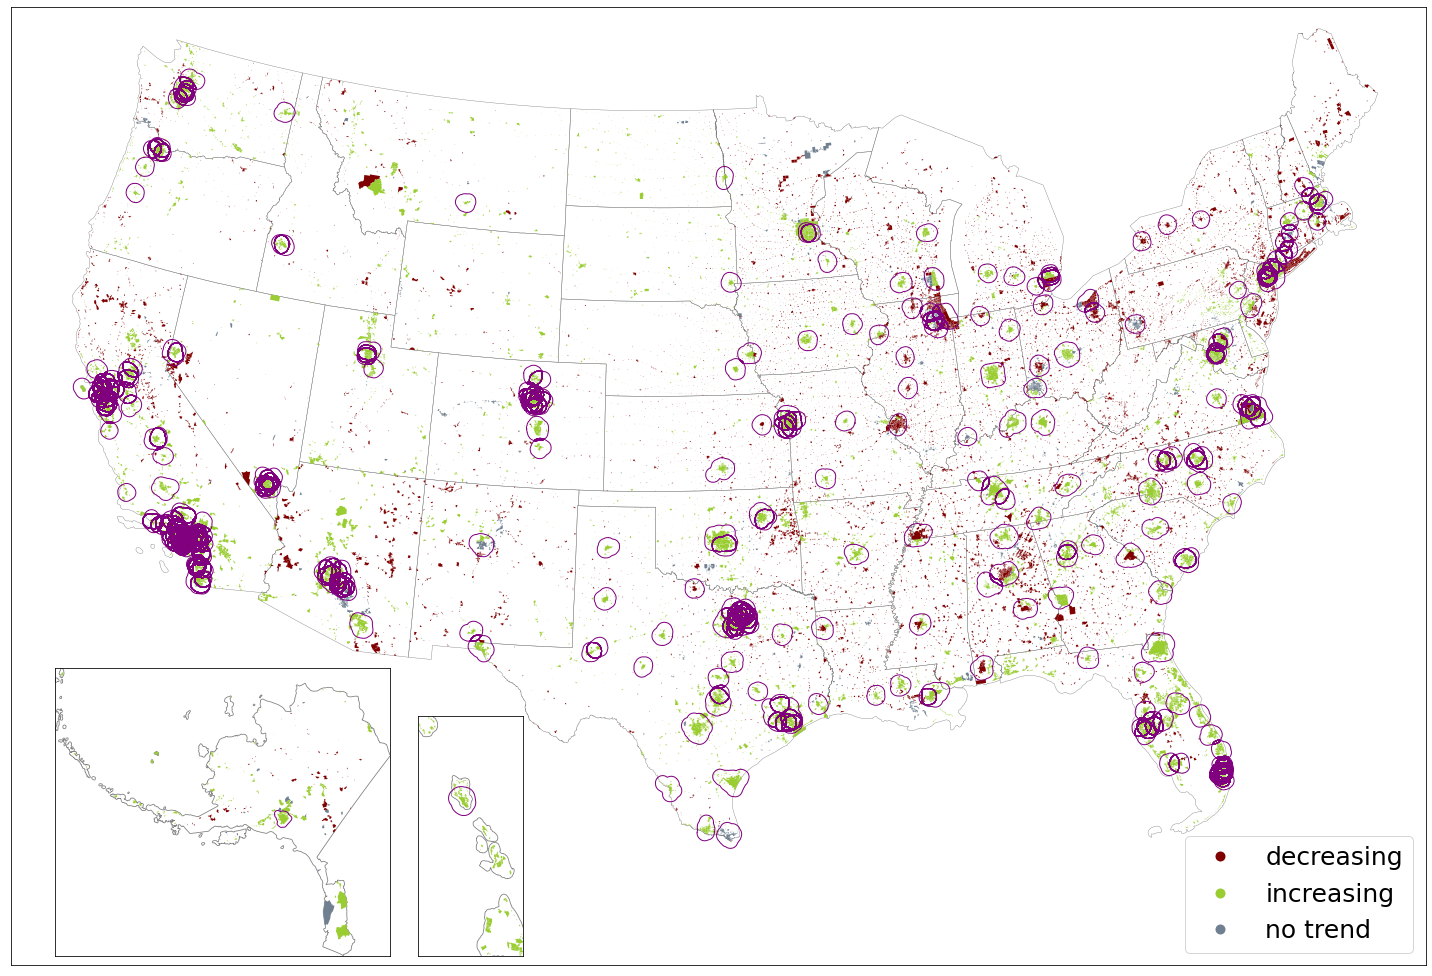

In [213]:
# import the United States shape file
# set state code as index, exclude states that we will never display
gdf = df.set_index('STATEFP') #.drop(index=['02', 'VI', 'MP', 'GU', 'AS'])
colors = ['maroon','yellowgreen','slategray']
column_name = "expected_trend_2"
# create an axis with 2 insets − this defines the inset sizes
fig, continental_ax = plt.subplots(figsize=(20, 20))
alaska_ax = continental_ax.inset_axes([.01, .01, .28, .30])
hawaii_ax = continental_ax.inset_axes([.20, .01, .25, .25])

# Set bounds to fit desired areas in each plot
continental_ax.set_xlim(-2257388.37, 2695859.75)
continental_ax.set_ylim(-2546944.04, 808080.9)
#[-8532676.07614065, -3748050.80000724,  3754325.60307967, 4852777.56870515]
alaska_ax.set_xlim(-4383115.86156959, -1515327.22537998)
alaska_ax.set_ylim(1458524.37417163, 3919523.37426209)

hawaii_ax.set_xlim(-5722090.887043, -5462538.83170424)   # bounds found for only populated places in Hawaii
hawaii_ax.set_ylim(-1044618.58269969, -455238.37803499)
#[-6440340.62278472, -1056683.73964088, -5453622.10058784, 1580494.49019997] # total bounds for Hawaii

# Plot the data per area - requires passing the same choropleth parameters to each call
# because different data is used in each call, so automatically setting bounds won’t work
#vmin, vmax = df['ALAND'].agg(['min', 'max'])
US_states.plot(ax=continental_ax, facecolor = 'none', edgecolor='gray', linewidth=0.4)
gdf.plot(column=column_name, 
                                  ax=continental_ax,
                                  cmap=matplotlib.colors.ListedColormap(colors), 
                                  legend = True,
                                  legend_kwds={'loc': 'lower right', 'fontsize': 25,}) #, vmin=vmin, vmax=vmax)
buffer2.plot(ax=continental_ax, edgecolor='purple', facecolor = 'none')

US_states.plot(facecolor = 'none', edgecolor='gray', linewidth=0.8, ax=alaska_ax)
gdf.plot(column=column_name, cmap=matplotlib.colors.ListedColormap(colors), ax=alaska_ax) #, vmin=vmin, vmax=vmax)
buffer_circles.plot(ax=alaska_ax, edgecolor='purple', facecolor = 'none')

US_states.plot(facecolor = 'none', edgecolor='gray', linewidth=0.8, ax=hawaii_ax)
gdf.plot(column=column_name, cmap=matplotlib.colors.ListedColormap(colors), ax=hawaii_ax,
                    missing_kwds = dict(color='black')) #, vmin=vmin, vmax=vmax)
buffer_circles.plot(ax=hawaii_ax, edgecolor='purple', facecolor = 'none')

# remove ticks
for ax in [continental_ax, alaska_ax, hawaii_ax]:
    ax.set_yticks([])
    ax.set_xticks([])
    plt.tight_layout() 
    

In [215]:
# df[df['NAME_x'] == 'Dixon']